**Создание датасета**

In [2]:
import lmdb
import os
import pickle
import argparse
import logging
import numpy as np
from datetime import datetime

import torch
from tqdm import tqdm
from CubiCasa5K.floortrans.loaders.svg_loader import FloorplanSVG

Определение функции для преобразования датасета из png/svg в тензорный датасет

In [16]:
def main(args, logger):
    logger.info("Opening database...")
    env = lmdb.open(args.lmdb, map_size=int(200e9))

    logger.info("Creating data loader...")
    data = FloorplanSVG(args.data_path, args.txt, format='txt', original_size=True)

    logger.info("Parsing data...")
    if args.overwrite:
        for d in tqdm(data):
            key = d['folder']
            logger.info("Adding " + key)
            with env.begin(write=True, buffers=True) as txn:
                txn.put(key.encode('ascii'), pickle.dumps(d))
    else:
        folders = np.genfromtxt(args.data_path + args.txt, dtype='str')
        for i, f in tqdm(enumerate(folders), total=len(folders)):
            with env.begin(write=True, buffers=True) as txn:
                elem = txn.get(f.encode('ascii'))
                if not elem:
                    logger.info("Adding " + f)
                    elem = data[i]
                    #elem['image'] = elem['image'].to(torch.uint8)
                    #elem['label'] = elem['label'].to(torch.uint8)
                    txn.put(f.encode('ascii'), pickle.dumps(elem))
                else:
                    logger.info(f + ' already exists')
    logger.info("Database creation complete.")

Запуск процесса генерации датасета

In [ ]:
if __name__ == '__main__':
    time_stamp = datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
    parser = argparse.ArgumentParser(description='Script for creating lmdb database.')
    parser.add_argument('--txt', nargs='?', type=str, default='', required=True,
                        help='Path to text file containing file paths')
    parser.add_argument('--lmdb', nargs='?', type=str,
                        default='data/cubicasa5k/cubi_lmdb/', help='Path to lmdb')
    parser.add_argument('--data-path', nargs='?', type=str, default='CubiCasa5K/data/cubicasa5k/',
                        help='Path to data directory')
    parser.add_argument('--log-path', nargs='?', type=str, default='runs_cubi/',
                        help='Path to log directory')
    parser.add_argument('--overwrite', nargs='?', type=bool, default=False,
                        const=True, help='Overwrite existing data')
    args = parser.parse_args()

    log_dir = args.log_path + '/' + time_stamp.replace(":", ".") + '/'
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    logger = logging.getLogger('lmdb')
    logger.setLevel(logging.DEBUG)
    fh = logging.FileHandler(log_dir+'/lmdb.log')
    fh.setLevel(logging.DEBUG)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fh.setFormatter(formatter)
    logger.addHandler(fh)

    main(args, logger)

**UNet**

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from timeit import default_timer as timer
import torch.optim as optim
import torch.nn.functional as F
import torchmetrics
from tqdm.auto import tqdm
import json
from typing import Dict, List, Tuple

Создание заргрузчиков данных

In [4]:
class PlanDataset(Dataset):
    def __init__(self, file_paths, deterministic=False):
        self.file_paths = file_paths
        if deterministic:  # To always generate the same test images for consistency
            np.random.seed(1)
        np.random.shuffle(self.file_paths)
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        return torch.load(file_path)

directory = './CubiCasa5K/data/cubicasa5k/train/'
files_and_dirs = os.listdir(directory)
files = [directory+f for f in files_and_dirs if os.path.isfile(os.path.join(directory, f))]

train_df = PlanDataset(files)

directory = './CubiCasa5K/data/cubicasa5k/val/'
files_and_dirs = os.listdir(directory)
files = [directory+f for f in files_and_dirs if os.path.isfile(os.path.join(directory, f))]

val_df = PlanDataset(files, True)

train_dataloader = DataLoader(train_df, batch_size=7, shuffle=True)
val_dataloader = DataLoader(val_df, batch_size=7, shuffle=False)

Создание класса модели

In [5]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.encoder_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            activation
        )
    def forward(self, x):
        return  self.encoder_block(x)
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            activation
        )
    def forward(self, x):
        return self.decoder_block(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Config
        in_channels  = 1   
        out_channels = 6   
        n_filters    = 32  # Scaled down from 64 in original paper
        activation   = nn.ReLU()
        
        # Up and downsampling methods
        self.downsample  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)

        self.open = nn.Sequential(
            nn.Conv2d(in_channels, n_filters, kernel_size=7, padding=3),
            activation,
            nn.Conv2d(n_filters, n_filters, kernel_size=5, padding=2),
            activation
        )
        
        # Encoder
        self.enc_block_1 = EncoderBlock(n_filters, n_filters)
        self.enc_block_2 = EncoderBlock(n_filters, 2*n_filters)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters)
        
        # Bottleneck
        self.bottleneck  = nn.Sequential(
            nn.Conv2d(8*n_filters, 16*n_filters, kernel_size=3, padding=1),
            activation,
            nn.Conv2d(16*n_filters, 16*n_filters, kernel_size=3, padding=1),
            activation
        )
        
        # Decoder
        self.dec_block_4 = DecoderBlock(16*n_filters, 8*n_filters)
        self.dec_block_3 = DecoderBlock(8*n_filters, 4*n_filters)
        self.dec_block_2 = DecoderBlock(4*n_filters, 2*n_filters)
        self.dec_block_1 = DecoderBlock(2*n_filters, n_filters)
        
        # Up-conv
        self.up4 = nn.Sequential(nn.Conv2d(16*n_filters, 8*n_filters, kernel_size=3, padding=1), activation)
        self.up3 = nn.Sequential(nn.Conv2d(8*n_filters, 4*n_filters, kernel_size=3, padding=1), activation)
        self.up2 = nn.Sequential(nn.Conv2d(4*n_filters, 2*n_filters, kernel_size=3, padding=1), activation)
        self.up1 = nn.Sequential(nn.Conv2d(2*n_filters, n_filters, kernel_size=3, padding=1), activation)
        
        # Output projection
        self.output = nn.Conv2d(n_filters, out_channels, kernel_size=(1,1), stride=1, padding=0)

        
    def forward(self, x):
        open = self.open(x)
        # Encoder
        enc1 = self.enc_block_1(open)
        enc2 = self.enc_block_2(self.downsample(enc1))
        enc3 = self.enc_block_3(self.downsample(enc2))
        enc4 = self.enc_block_4(self.downsample(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.downsample(enc4))
        
        # Decoder
        dec4 = self.dec_block_4(torch.cat([self.upsample(self.up4(bottleneck)), enc4], dim=1))
        dec3 = self.dec_block_3(torch.cat([self.upsample(self.up3(dec4)), enc3], dim=1))
        dec2 = self.dec_block_2(torch.cat([self.upsample(self.up2(dec3)), enc2], dim=1))
        dec1 = self.dec_block_1(torch.cat([self.upsample(self.up1(dec2)), enc1], dim=1))

        res = self.output(dec1)
        
        return res

# Function to count number of parameters in a model for comparisons later
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total Parameters: {total_params:,}\n')

# Function that saves a model to specified path
def save_model(model, path='model_weights.pth'):
    torch.save(model.state_dict(), path)

Опредление функции обучения

In [61]:
def iou(pred, target):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    if union == 0:
        return torch.tensor(1.0)
    return intersection / union

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    model.train()
    train_loss, train_iou = 0, 0

    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader), leave=False, desc='Train'):
        X = X/255
        y = y.to(torch.float32)
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred = y_pred.detach()
        zone_pred = y_pred[:, :3]
        icon_pred = y_pred[:, 3:]
        zone_pred = F.softmax(zone_pred, dim=1)
        icon_pred = F.softmax(icon_pred, dim=1)
        
        zone_pred[:, 0][torch.argmax(zone_pred, dim=1) == 0] = 1
        zone_pred[:, 1][torch.argmax(zone_pred, dim=1) == 1] = 1
        zone_pred[:, 2][torch.argmax(zone_pred, dim=1) == 2] = 1

        icon_pred[:, 0][torch.argmax(icon_pred, dim=1) == 0] = 1
        icon_pred[:, 1][torch.argmax(icon_pred, dim=1) == 1] = 1
        icon_pred[:, 2][torch.argmax(icon_pred, dim=1) == 2] = 1
        
        zone_true = y[:, :3]
        icon_true = y[:, 3:]
        
        train_iou += iou(zone_pred, zone_true) + iou(icon_pred, icon_true)

    train_loss /= len(dataloader)
    train_iou /= 2*len(dataloader)


    return train_loss, train_iou

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    model.eval()
    test_loss, test_iou = 0, 0

    z_iou, i_iou = 0, 0

    with torch.no_grad():
        for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader), leave=False, desc='Test'):
            X = X/255
            y = y.to(torch.float32)
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            y_pred = y_pred.detach()
            zone_pred = y_pred[:, :3]
            icon_pred = y_pred[:, 3:]
            zone_pred = F.softmax(zone_pred, dim=1)
            icon_pred = F.softmax(icon_pred, dim=1)
        
            zone_pred[:, 0][torch.argmax(zone_pred, dim=1) == 0] = 1
            zone_pred[:, 1][torch.argmax(zone_pred, dim=1) == 1] = 1
            zone_pred[:, 2][torch.argmax(zone_pred, dim=1) == 2] = 1

            icon_pred[:, 0][torch.argmax(icon_pred, dim=1) == 0] = 1
            icon_pred[:, 1][torch.argmax(icon_pred, dim=1) == 1] = 1
            icon_pred[:, 2][torch.argmax(icon_pred, dim=1) == 2] = 1
        
            zone_true = y[:, :3]
            icon_true = y[:, 3:]

            zz = 0
            ii = 0
        
            test_iou += iou(zone_pred, zone_true) + iou(icon_pred, icon_true)
            for i in range(len(y)):
                p = POST(zone_pred[i].to('cpu').detach().numpy(), icon_pred[i].to('cpu').detach().numpy())
                p[p>0]=1
                z = iou(torch.tensor(p[:3]).to('cuda'), zone_pred[i])
                j = iou(torch.tensor(p[3:]).to('cuda'), icon_pred[i])
                zz += z
                ii += j
            ii/=len(y)
            zz/=len(y)
            print(len(y))

            print(zz)
            print(ii)

            z_iou += zz
            i_iou += ii

    test_loss /= len(dataloader)
    test_iou /= 2*len(dataloader)

    z_iou /= len(dataloader)
    i_iou /= len(dataloader)

    return test_loss, test_iou, z_iou, i_iou


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    results = {"train_loss": [],
               "train_iou": [],
               "test_loss": [],
               "test_iou": []
    }

    model.to(device)
    max_iou = 0
    for epoch in tqdm(range(epochs)):
        train_loss, train_iou = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_iou = test_step(model=model,
                                          dataloader=test_dataloader,
                                          loss_fn=loss_fn,
                                          device=device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.3f} | "
          f"train_iou: {train_iou:.3f} | "
          f"test_loss: {test_loss:.3f} | "
          f"test_iou: {test_iou:.3f}"
        )

        results["train_loss"].append(train_loss)
        results["train_iou"].append(train_iou)
        results["test_loss"].append(test_loss)
        results["test_iou"].append(test_iou)

        torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
            }, f"{epochs}_iter.pth")

    return results

Создание объекта модели

In [7]:
model = UNet()
print(f'Число обучаемых параметров: {count_parameters(model)}')

Total Parameters: 8,666,246

Число обучаемых параметров: None


Определение параметров обучения

In [39]:
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCEWithLogitsLoss()

#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 1
device='cuda'

Обучение модели

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

result = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=n_epochs,
                       device=device)
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

Назначение весов из уже обучнной модели

In [35]:
weights_path = './Train UNet/UNet_weights.pth'
checkpoint = torch.load(weights_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Сохранение метрик из процесса обучения

In [ ]:
for key in result.keys():
    for idx, value in enumerate(result[key]):
        if isinstance(value, torch.Tensor):
            result[key][idx] = value.item()
            
with open('./Train UNet/results.json', 'w', encoding='utf-8') as json_file:
    json.dump(result, json_file, ensure_ascii=False, indent=4)

print('Done')

**Просмотр результата**

In [15]:
import json
import matplotlib.pyplot as plt
import numpy as np

Извлечение записанного результата

In [16]:
def load_json(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return json.load(f)

result = load_json('./Train UNet/result.json')

Визуализция

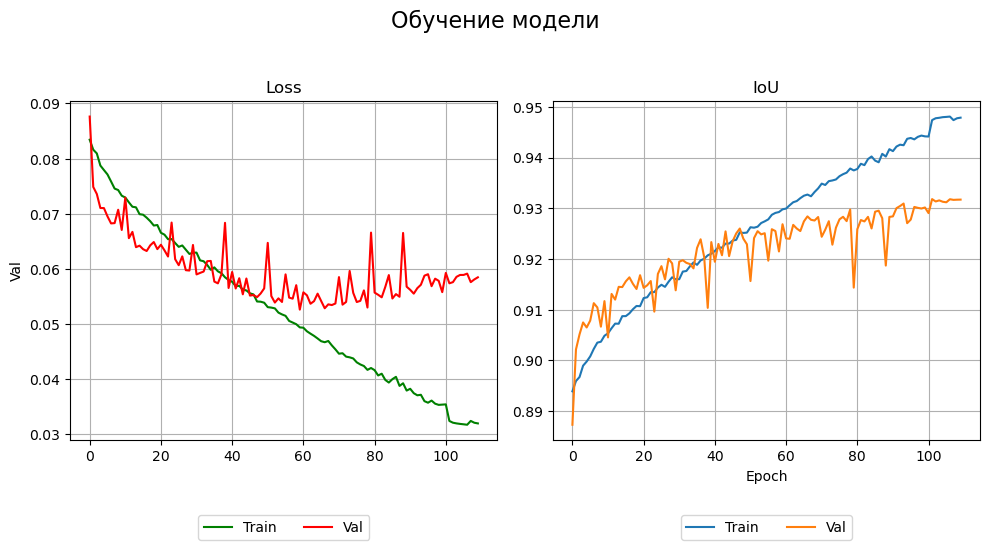

In [17]:
x = range(0, 110)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.plot(x, result['train_loss'], label='Train', c = 'g')
ax1.plot(x, result['test_loss'], label='Val', c = 'r')
ax1.set_title('Loss')
ax1.set_ylabel('Val')
ax1.legend()
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
ax1.grid(True)

ax2.plot(x, result['train_iou'], label='Train')
ax2.plot(x, result['test_iou'], label='Val')
ax2.set_title('IoU')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
ax2.grid(True)

fig.suptitle('Обучение модели', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [18]:
print('Окончательный резльат обучения: \n')
for i in result.keys():
    print(i, result[i][-1])

Окончательный резльат обучения: 

train_loss 0.032000709321970744
train_iou 0.9478721618652344
test_loss 0.05848308016770873
test_iou 0.9317145347595215


Расчёт на тестовой выборке:

In [36]:
directory = './CubiCasa5K/data/cubicasa5k/test/'
files_and_dirs = os.listdir(directory)
files = [directory+f for f in files_and_dirs if os.path.isfile(os.path.join(directory, f))]

test_df = PlanDataset(files, True)

val_df = PlanDataset(files, True)
test_dataloader = DataLoader(test_df, batch_size=7, shuffle=False)

In [49]:
def predict(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          device: torch.device) -> Dict[str, List]:

    model.to(device)
    max_iou = 0
    for epoch in range(1):
        test_loss, test_iou, z_iou, i_iou = test_step(model=model,
                                          dataloader=test_dataloader,
                                          loss_fn=loss_fn,
                                          device=device)

        print(
          f"test_loss: {test_loss:.3f} | "
          f"test_loss: {test_iou:.3f} | "
          f"z_iou: {z_iou:.3f} | "
          f"i_iou: {i_iou:.3f}"
        )
        results = {}
        results["test_loss"] = test_loss
        results["test_iou"] = test_iou

    return results

In [62]:
predict(model, test_dataloader,loss_fn=loss_fn, device=device)

Test:   0%|          | 0/58 [00:00<?, ?it/s]

7
tensor(0.8980, device='cuda:0')
tensor(0.3362, device='cuda:0')
7
tensor(0.9067, device='cuda:0')
tensor(0.3370, device='cuda:0')
7
tensor(0.8617, device='cuda:0')
tensor(0.3366, device='cuda:0')
7
tensor(0.8116, device='cuda:0')
tensor(0.3374, device='cuda:0')
7
tensor(0.8394, device='cuda:0')
tensor(0.3371, device='cuda:0')
7
tensor(0.8459, device='cuda:0')
tensor(0.3377, device='cuda:0')
7
tensor(0.8012, device='cuda:0')
tensor(0.3406, device='cuda:0')
7
tensor(0.9105, device='cuda:0')
tensor(0.3374, device='cuda:0')
7
tensor(0.8995, device='cuda:0')
tensor(0.3368, device='cuda:0')
7
tensor(0.8735, device='cuda:0')
tensor(0.3365, device='cuda:0')
7
tensor(0.9153, device='cuda:0')
tensor(0.3368, device='cuda:0')
7
tensor(0.9071, device='cuda:0')
tensor(0.3410, device='cuda:0')
7
tensor(0.8626, device='cuda:0')
tensor(0.3352, device='cuda:0')
7
tensor(0.8795, device='cuda:0')
tensor(0.3364, device='cuda:0')
7
tensor(0.8918, device='cuda:0')
tensor(0.3397, device='cuda:0')
7
tensor(0

{'test_loss': 0.075521738043633, 'test_iou': tensor(0.9349, device='cuda:0')}

**Просмотр результатов**

In [20]:
import torch
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from CubiCasa5K.floortrans.models import get_model

In [21]:
def resize_with_padding(image, target_size=(512, 512), background_color=0):
    target_w, target_h = target_size
    original_w, original_h = image.size
    
    scale = min(target_w / original_w, target_h / original_h)
    new_w = int(original_w * scale)
    new_h = int(original_h * scale)
    
    resized_image = image.resize((new_w, new_h), Image.LANCZOS)

    c1 = (target_w - new_w) // 2
    c2 = (target_h - new_h) // 2
    c3 = (target_w - new_w + 1) // 2
    c4 = (target_h - new_h + 1) // 2
    c = (c1, c2, c3, c4)
    padded_image = ImageOps.expand(resized_image, c, fill=background_color)
    return padded_image, c

def restore_image(padded_image, original_size, c):
    w, h = padded_image.size
    c1, c2, c3, c4 = c
    left = c1
    upper = c2
    right = w - c3
    lower = h - c4
    cropped_image = padded_image.crop((left, upper, right, lower))
    return cropped_image.resize(original_size, Image.LANCZOS)

def show_image(image, title="Image", cmap='grey'):
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [22]:
def GetIm1(path, model):
    image = Image.open(path)
    bw, c = resize_with_padding(image.convert('L'), (512, 512), 255)
    tns = torch.tensor([[np.array(bw)/255]]).to('cuda').to(torch.float)
    with torch.no_grad():
        model.cuda()
        res = model(tns)

    zone_pred = res[:, :3]
    icon_pred = res[:, 3:]
    zone_pred = F.softmax(zone_pred, dim=1)
    icon_pred = F.softmax(icon_pred, dim=1)
        
    zones = torch.argmax(zone_pred, dim=1)[0].to('cpu').detach().numpy()
    icons = torch.argmax(icon_pred, dim=1)[0].to('cpu').detach().numpy()
    return image, bw, zones, icons

In [26]:
im1 = GetIm1('./Train UNet/1.jpg', model)
im2 = GetIm1('./Train UNet/2.jpg', model)
im3 = GetIm1('./Train UNet/3.jpg', model)

In [27]:
model2 = get_model('hg_furukawa_original', 51)

n_classes = 44
split = [21, 12, 11]
model2.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model2.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
checkpoint = torch.load('./Train UNet/model_best_val_loss_var.pkl')

model2.load_state_dict(checkpoint['model_state'])
model2.eval()
model2.cuda()
print("Model loaded.")

Model loaded.


In [28]:
def GetIm2(path, model):
    image = Image.open(path)
    tns = torch.tensor([np.array(image)/255]).to('cuda').to(torch.float)
    tns=tns.permute(0, 3, 1, 2)
    with torch.no_grad():
        a = model(tns)
    rooms_pred = F.softmax(a[0, 21:21+12], 0).cpu().data.numpy()
    icons_pred = F.softmax(a[0, 21+12:], 0).cpu().data.numpy()
    zones = np.sum(np.stack([rooms_pred[1], rooms_pred[3], rooms_pred[4], rooms_pred[5], rooms_pred[6], rooms_pred[7], rooms_pred[8], rooms_pred[9], rooms_pred[10], rooms_pred[11]]), axis=0)
    zones = np.stack([rooms_pred[0], rooms_pred[2], zones])
    zero = np.ones_like(icons_pred[0])
    icons = np.stack([zero - icons_pred[1] - icons_pred[2], icons_pred[1], icons_pred[2]])
    return image, np.argmax(zones, axis=0), np.argmax(icons, axis=0)

In [29]:
im21 = GetIm2('./Train UNet/1.jpg', model2)
im22 = GetIm2('./Train UNet/2.jpg', model2)
im23 = GetIm2('./Train UNet/3.jpg', model2)

Результат обучения Unet

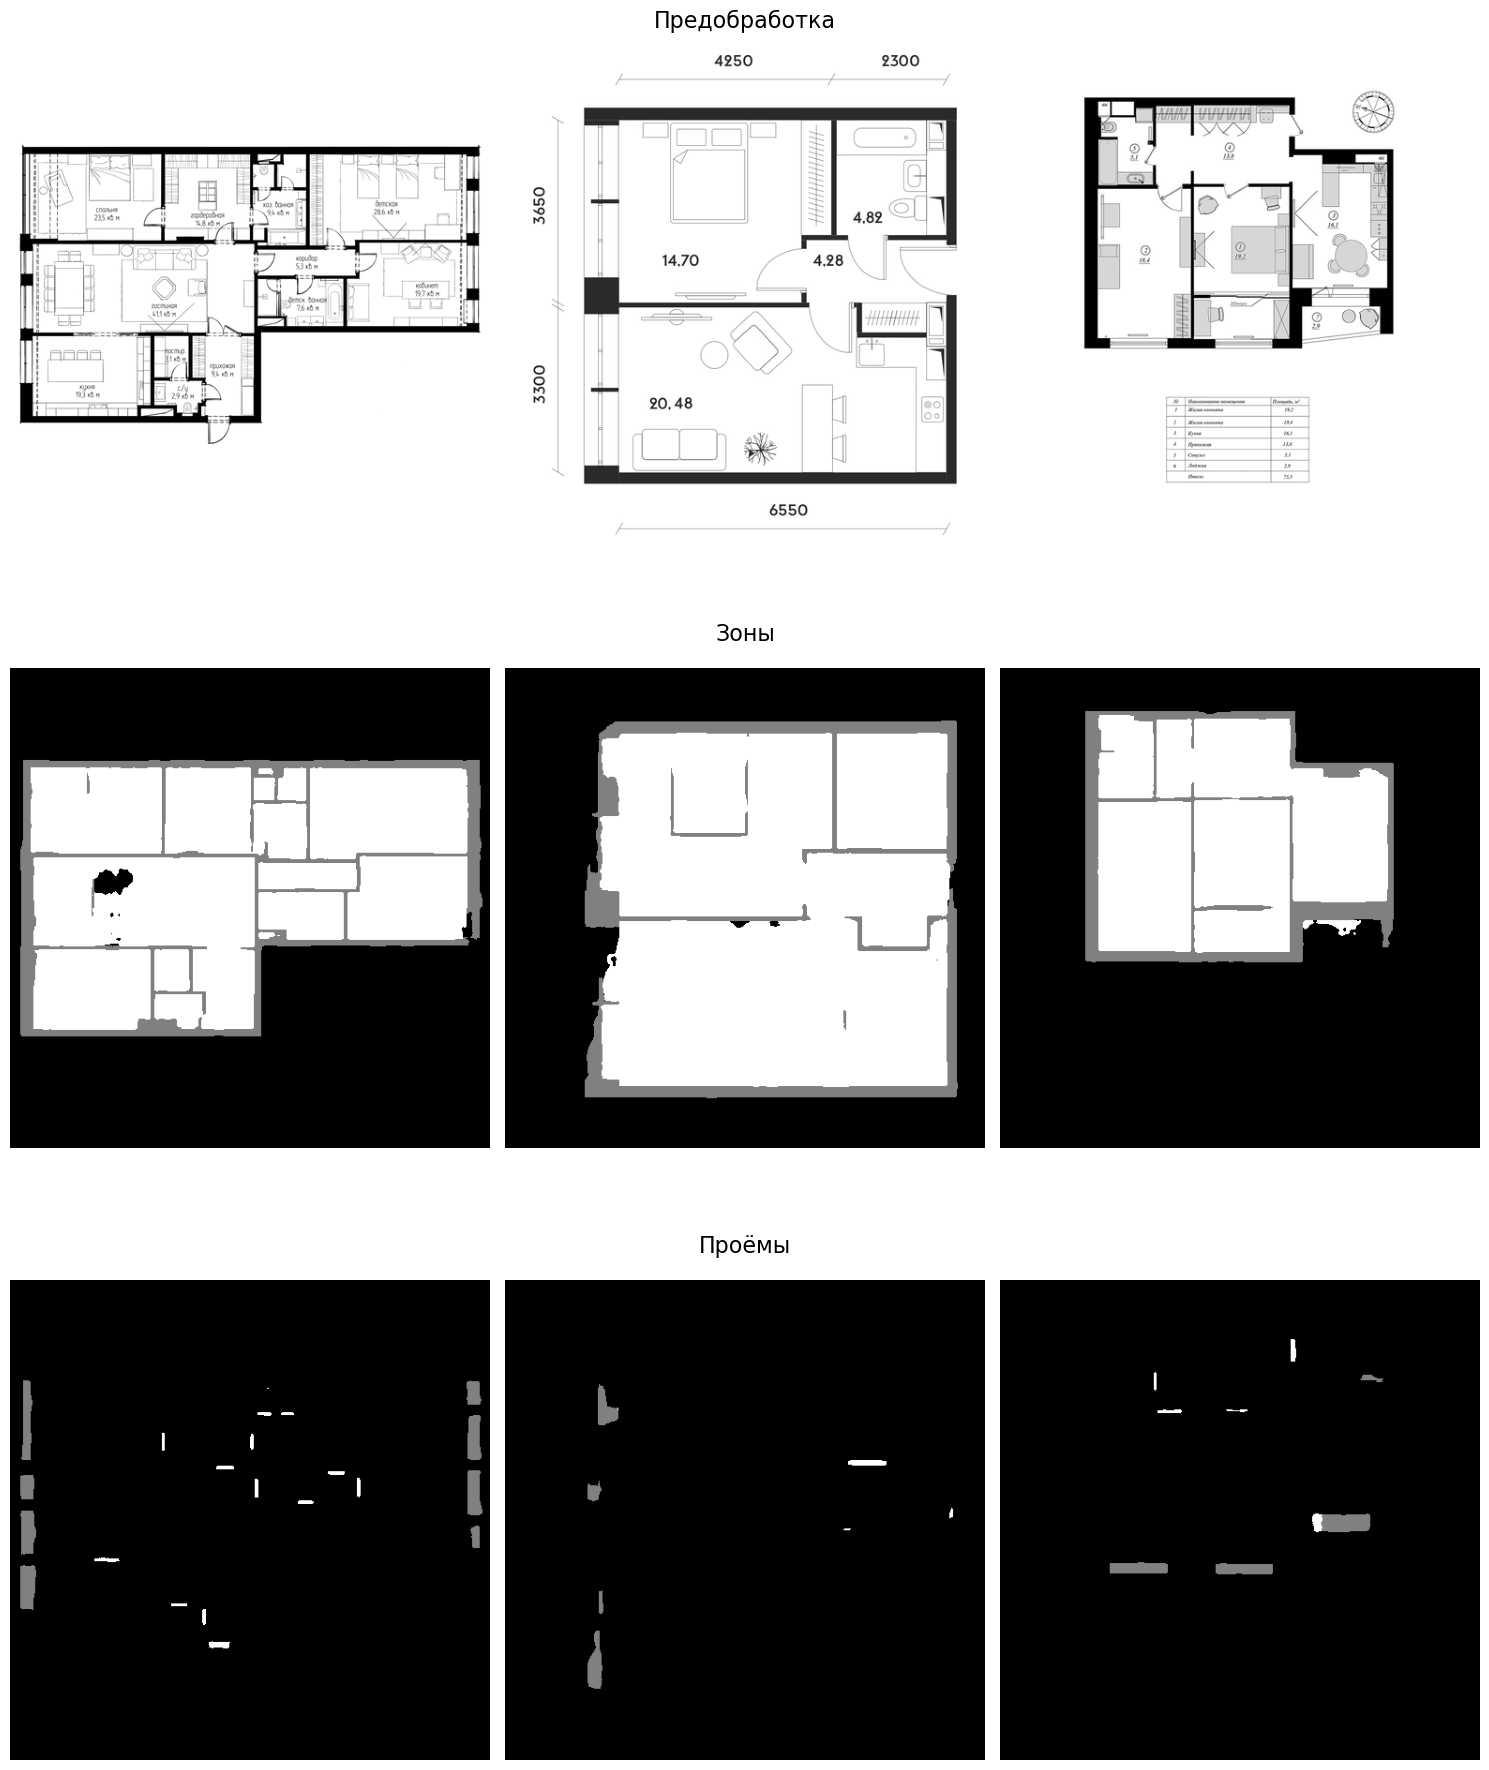

In [30]:
fig, axes = plt.subplots(3, 3, figsize=(15, 20))
row_titles = ['Предобработка', 'Зоны', 'Проёмы']
ims1 = [im1, im2, im3]
for i in range(3):
    for j in range(3):
        img = ims1[j][1:][i]
        axes[i, j].imshow(img,cmap='grey')
        axes[i, j].axis('off')
    axes[i, 1].set_title(row_titles[i], fontsize=16, pad=20)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

Результат предобученного ResNet

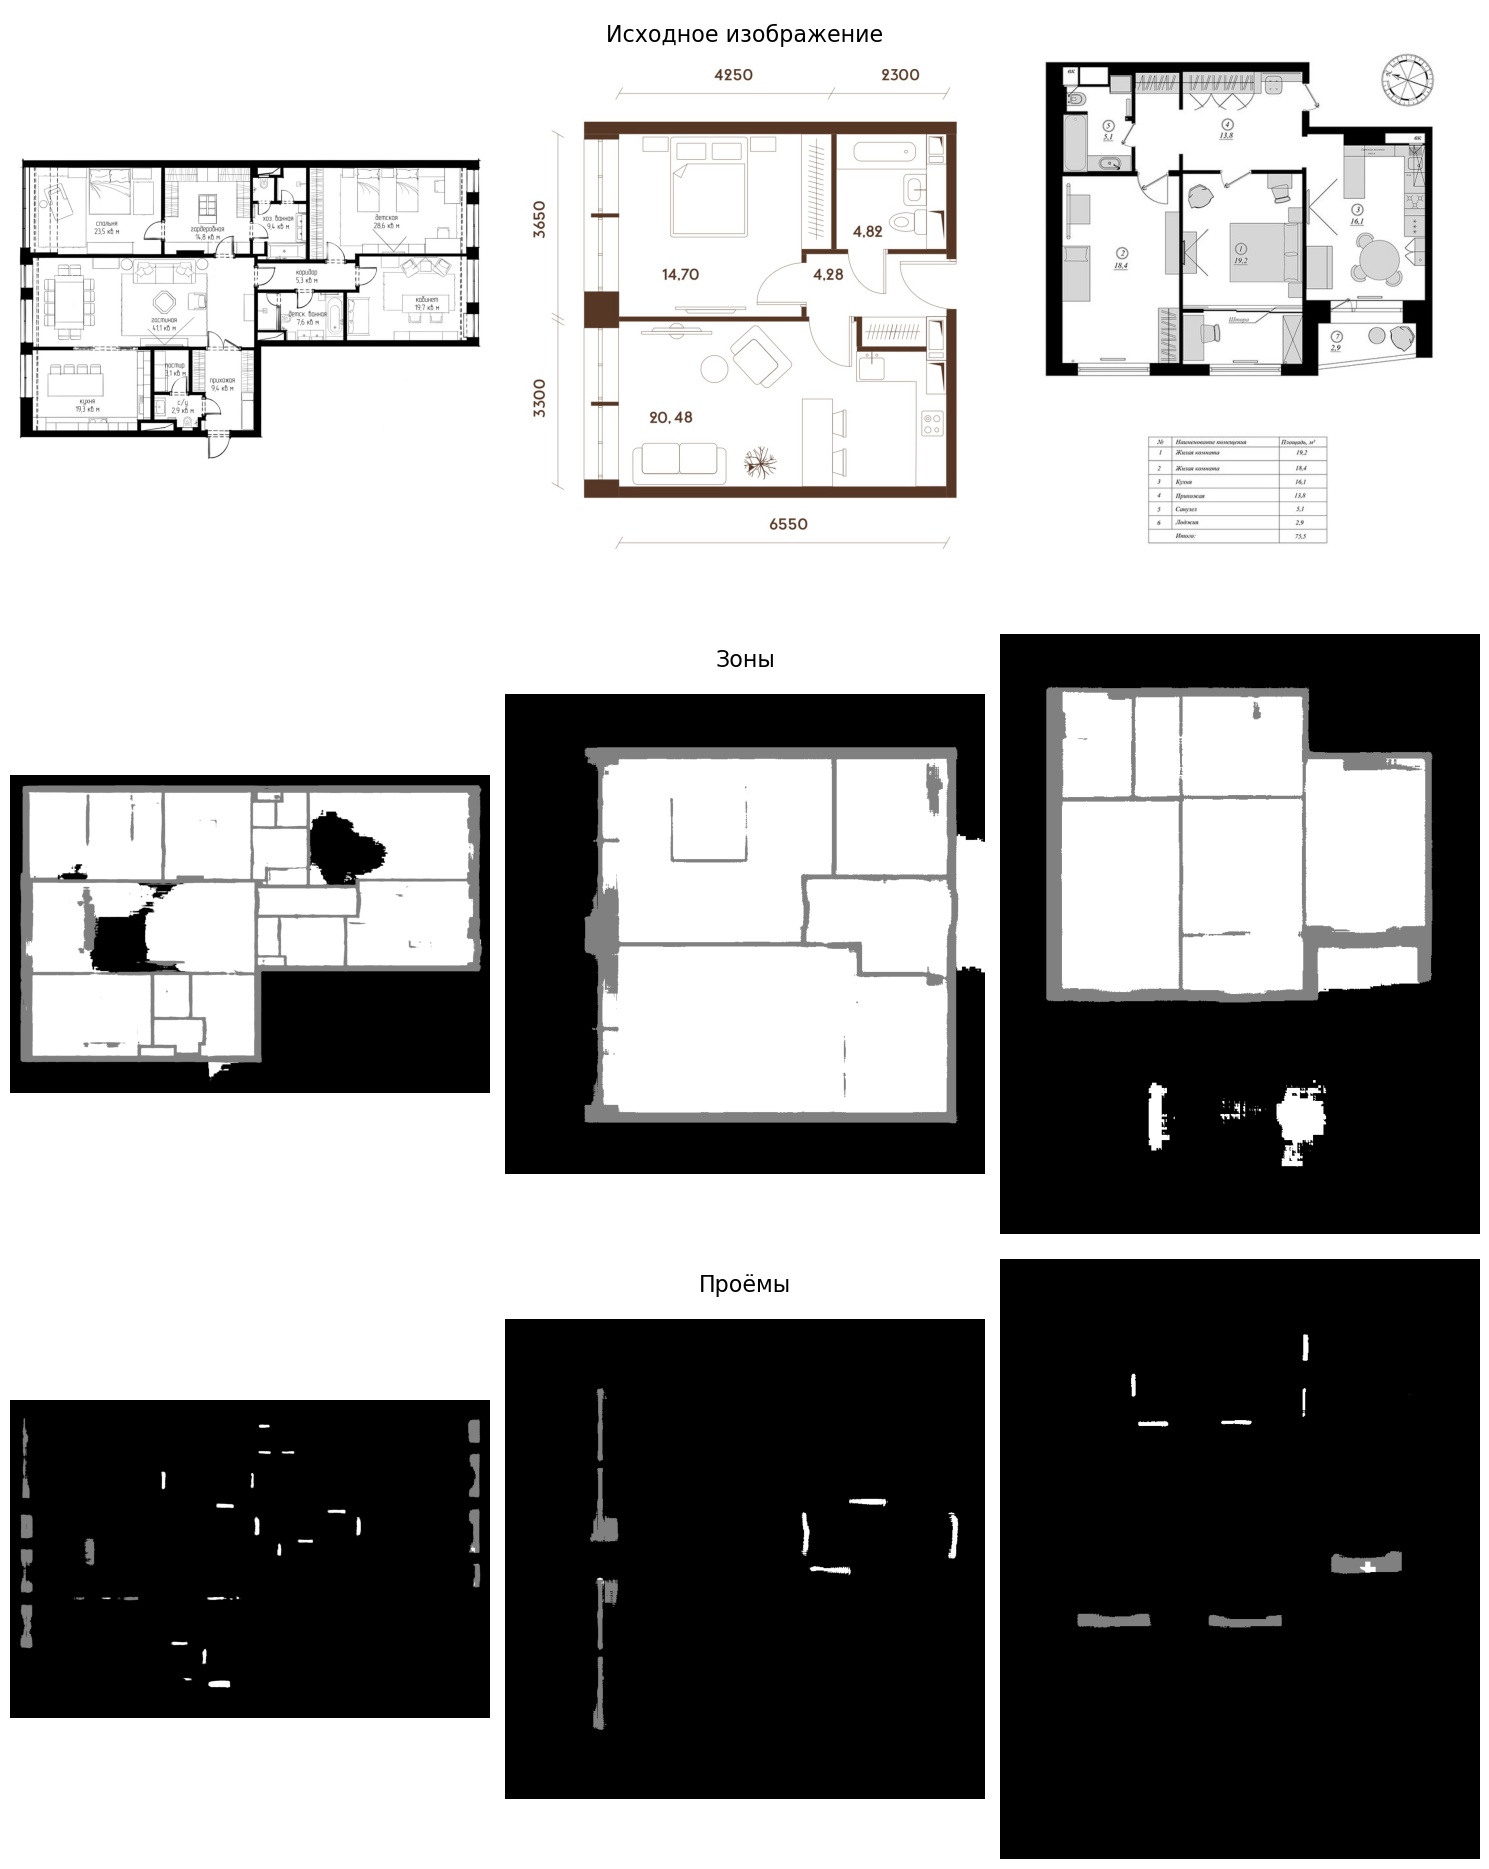

In [31]:
fig, axes = plt.subplots(3, 3, figsize=(15, 20))
row_titles = ['Исходное изображение', 'Зоны', 'Проёмы']
ims2 = [im21, im22, im23]
for i in range(3):
    for j in range(3):
        img = ims2[j][i]
        axes[i, j].imshow(img,cmap='grey')
        axes[i, j].axis('off')
    axes[i, 1].set_title(row_titles[i], fontsize=16, pad=20)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

Сравнение самостоятельно обученного UNet и предобученного Res-Net

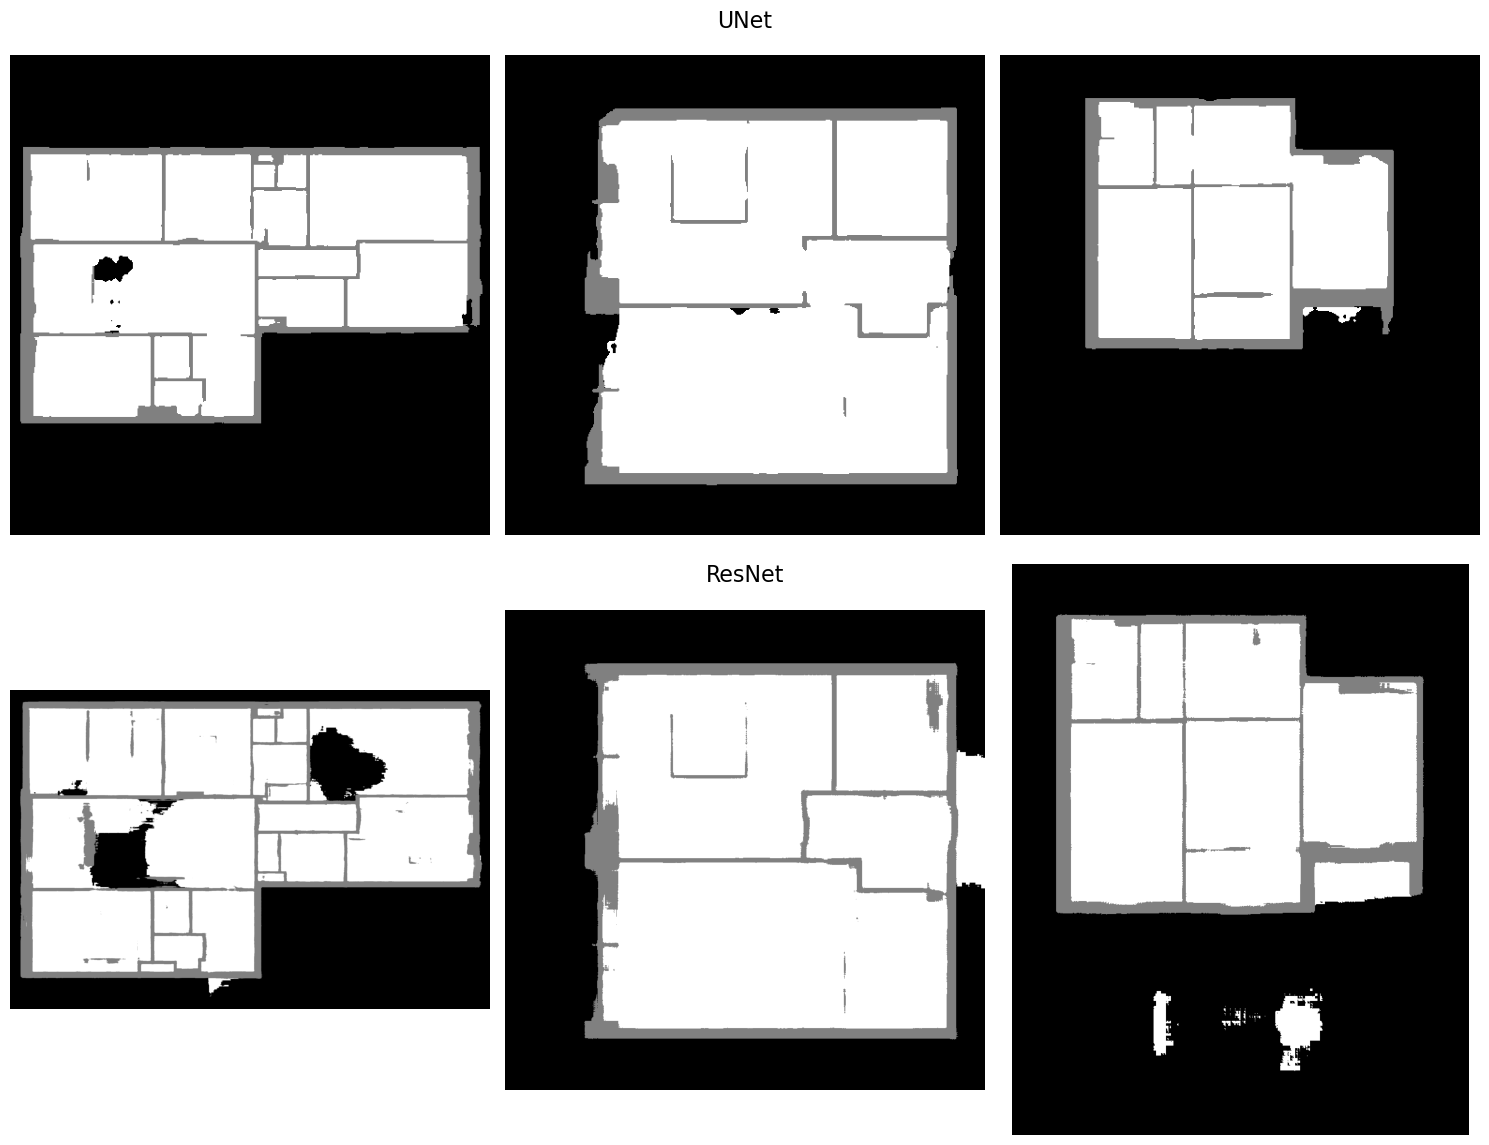

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
ims2 = [im21, im22, im23]

for j in range(3):
    img = ims1[j][2]
    axes[0, j].imshow(img,cmap='grey')
    axes[0, j].axis('off')
axes[0, 1].set_title('UNet', fontsize=16, pad=20)

for j in range(3):
    img = ims2[j][1]
    axes[1, j].imshow(img,cmap='grey')
    axes[1, j].axis('off')
axes[1, 1].set_title('ResNet', fontsize=16, pad=20)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

In [33]:
weights_path = './Compare/model_best_val_acc.pkl'
checkpoint = torch.load(weights_path)
model2.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

In [34]:
im21 = GetIm2('./Train UNet/1.jpg', model2)
im22 = GetIm2('./Train UNet/2.jpg', model2)
im23 = GetIm2('./Train UNet/3.jpg', model2)

Результат ResNet, который был обучен самостоятельно

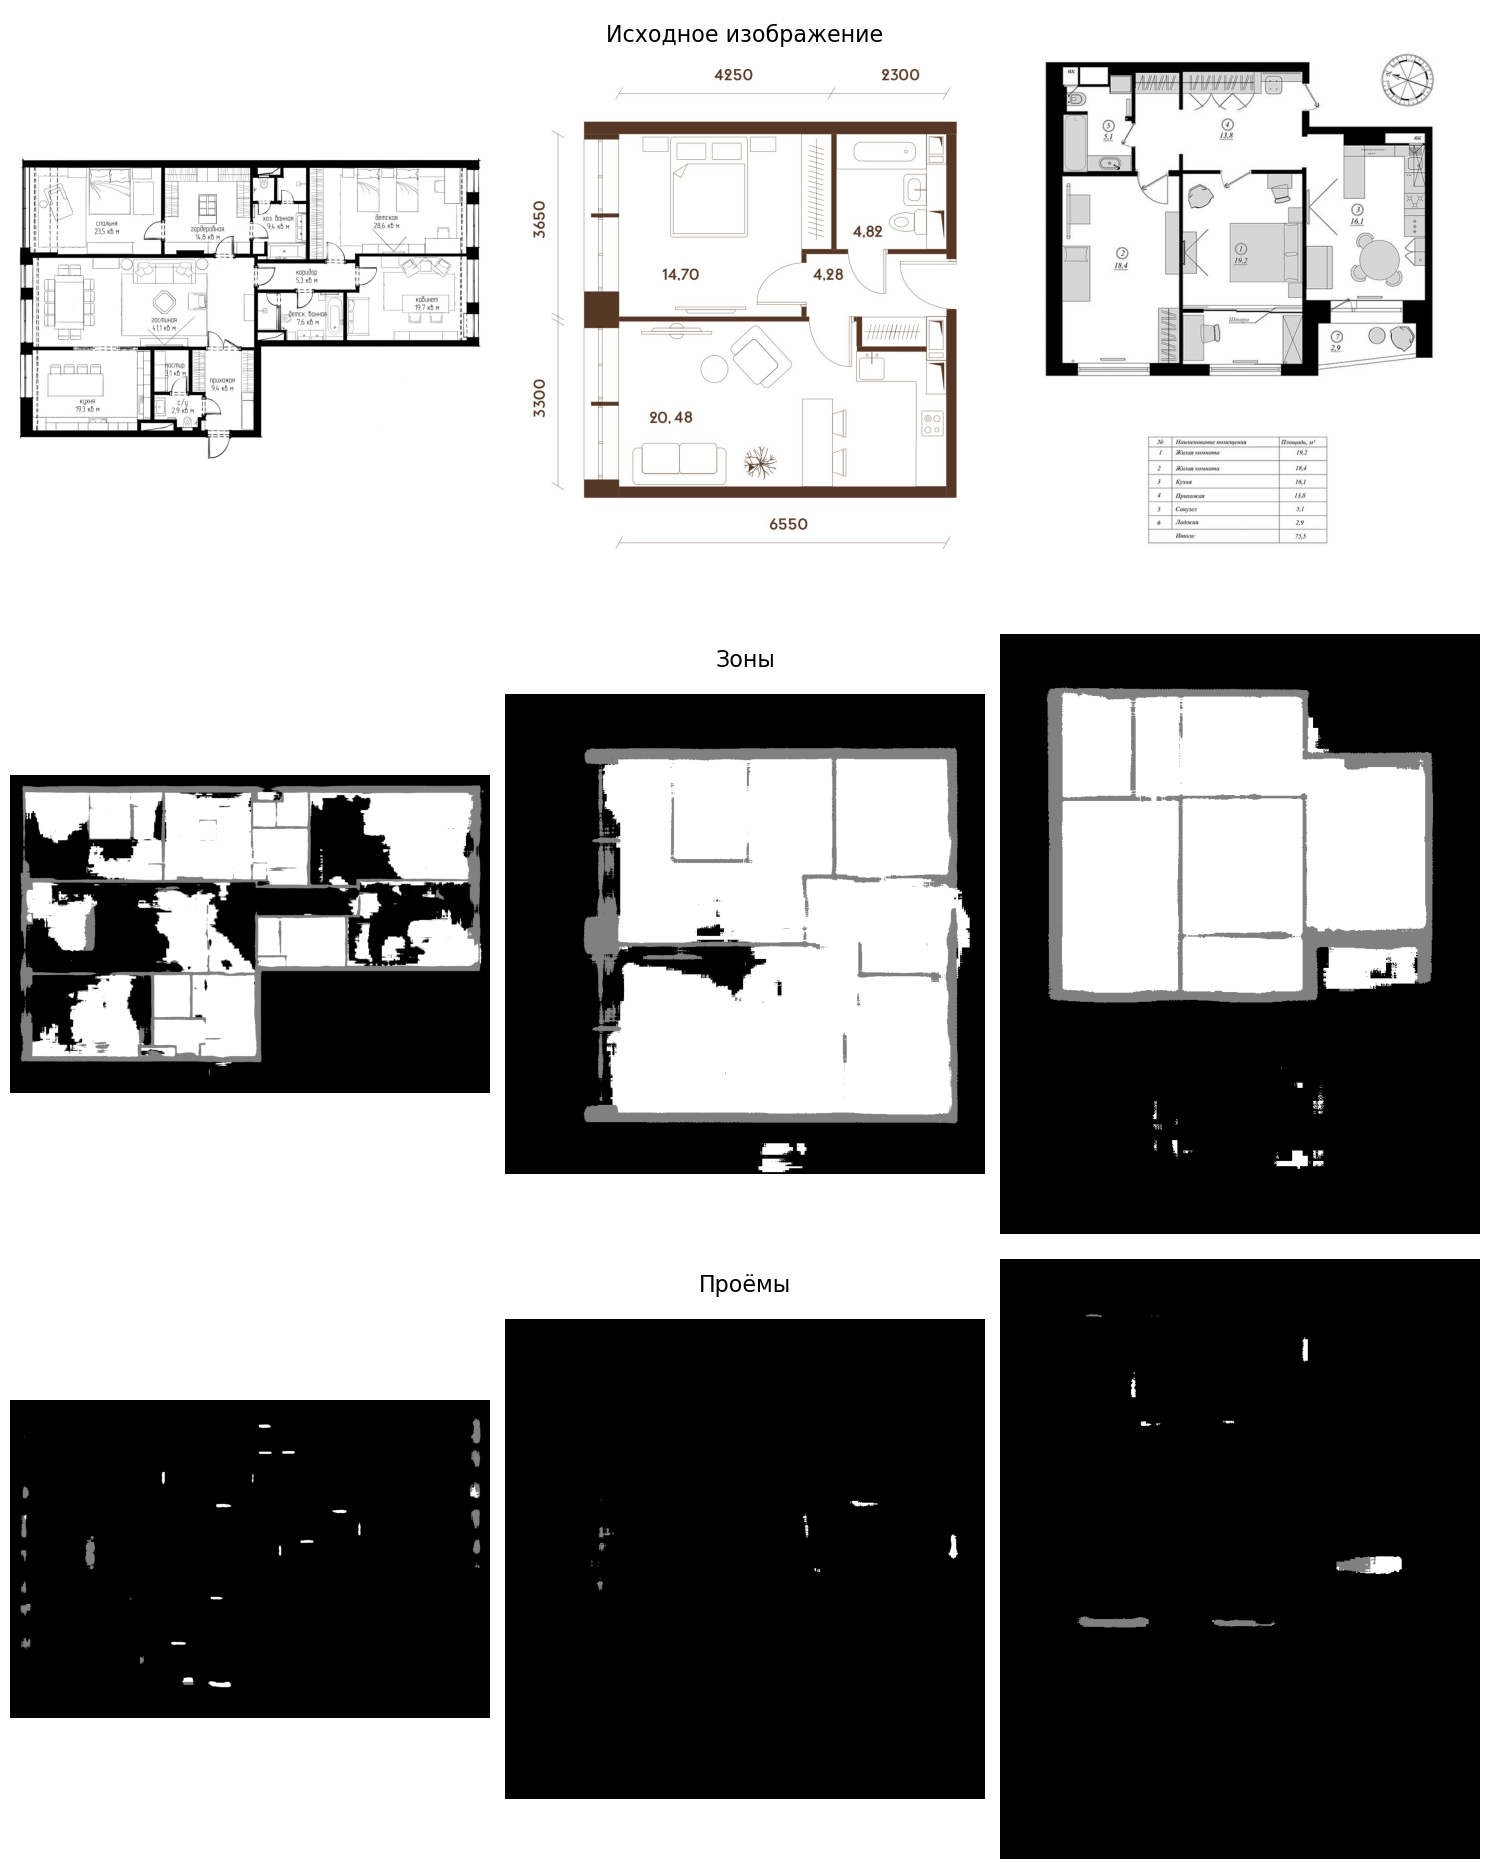

In [35]:
fig, axes = plt.subplots(3, 3, figsize=(15, 20))
row_titles = ['Исходное изображение', 'Зоны', 'Проёмы']
ims2 = [im21, im22, im23]
for i in range(3):
    for j in range(3):
        img = ims2[j][i]
        axes[i, j].imshow(img,cmap='grey')
        axes[i, j].axis('off')
    axes[i, 1].set_title(row_titles[i], fontsize=16, pad=20)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

Сравнение самостоятельно обученных UNet и Res-Net

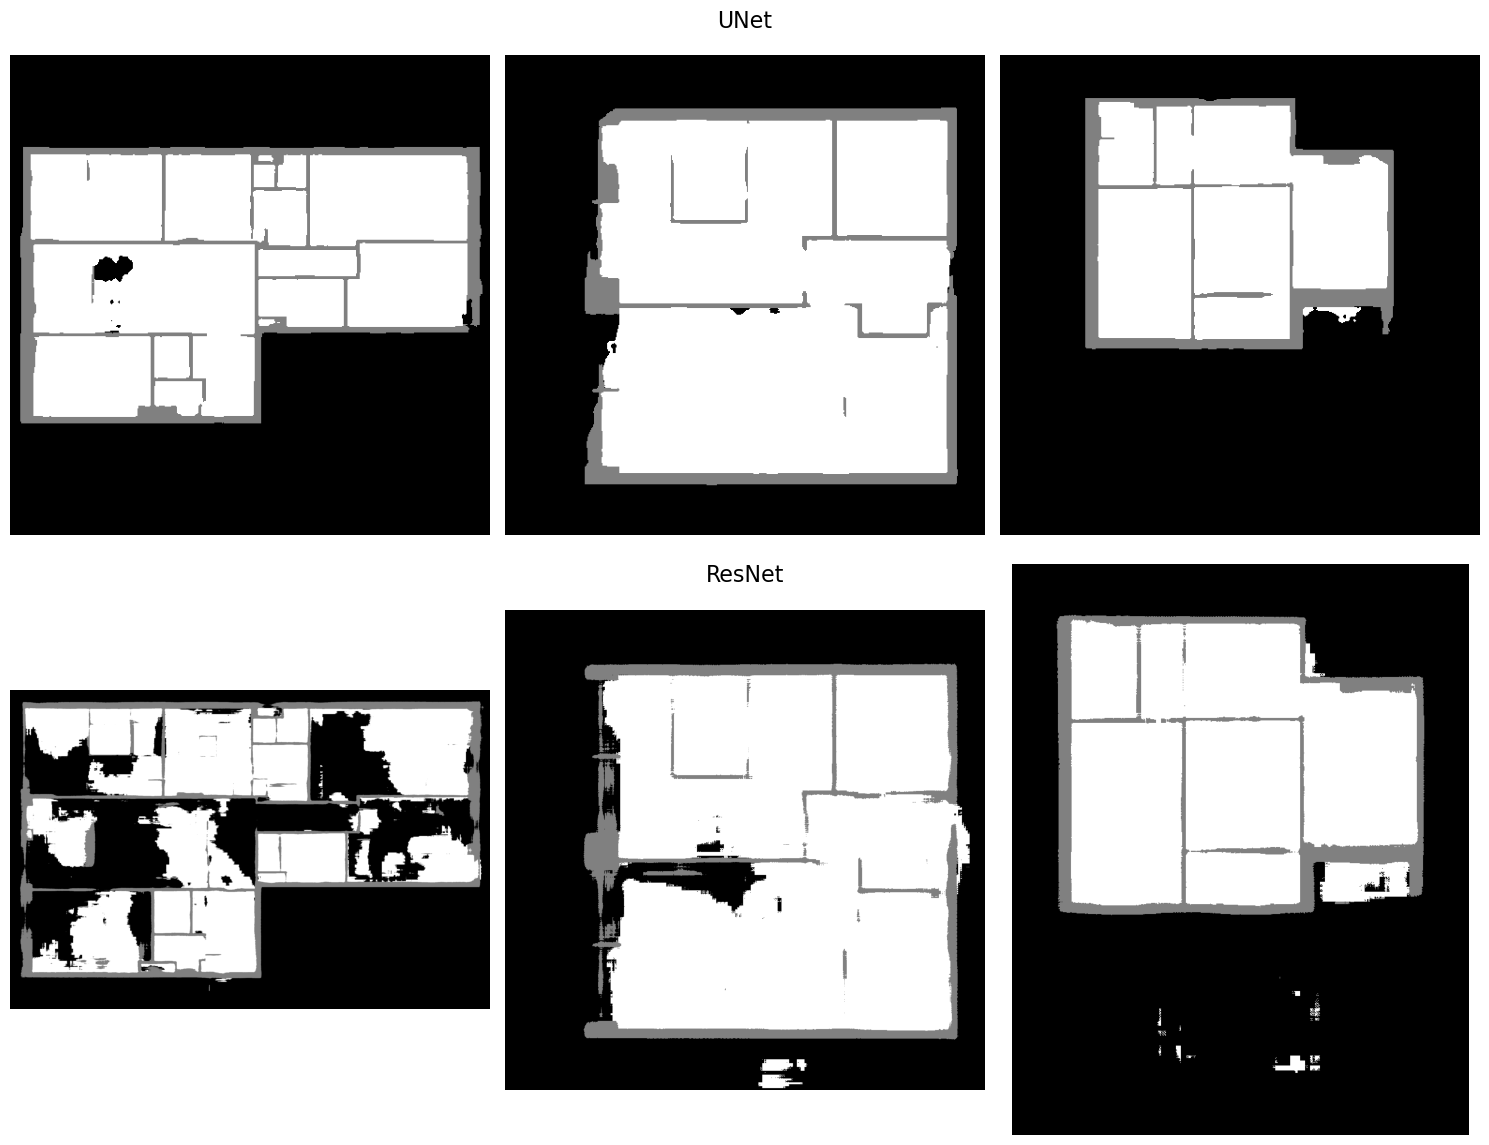

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
ims2 = [im21, im22, im23]

for j in range(3):
    img = ims1[j][2]
    axes[0, j].imshow(img,cmap='grey')
    axes[0, j].axis('off')
axes[0, 1].set_title('UNet', fontsize=16, pad=20)

for j in range(3):
    img = ims2[j][1]
    axes[1, j].imshow(img,cmap='grey')
    axes[1, j].axis('off')
axes[1, 1].set_title('ResNet', fontsize=16, pad=20)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

**Сохранение массива для постабработки**

In [37]:
im = GetIm1('./Train UNet/4.png', model)

In [38]:
np.save('./Post/plan.npy', np.array(im[1:]))

In [16]:
weights_path = '7.pth'
checkpoint = torch.load(weights_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [17]:
sp = []
for i in range(2, 19):
    sp += [str(i)+'.pth']

In [28]:
zzz = []
iii = []
for k in sp:
    weights_path = k
    checkpoint = torch.load(weights_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    im, bw, z, i = GetIm1('./Train UNet/1.jpg', model)
    zzz += [z*255/2]
    iii += [i*255/2]

In [31]:
import cv2
import numpy as np

for idx, matrix in enumerate(iii):
    filename = f'i_{idx}.png'
    cv2.imwrite(filename, matrix)
    print(f'Saved {filename}')

Saved i_0.png
Saved i_1.png
Saved i_2.png
Saved i_3.png
Saved i_4.png
Saved i_5.png
Saved i_6.png
Saved i_7.png
Saved i_8.png
Saved i_9.png
Saved i_10.png
Saved i_11.png
Saved i_12.png
Saved i_13.png
Saved i_14.png
Saved i_15.png
Saved i_16.png


In [33]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
import cv2

def inner(zo):
    zo = zo.copy()
    contours, hierarchy = cv2.findContours(zo[0], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    inner_spot_mask = np.zeros_like(zo[0])
    cv2.fillPoly(inner_spot_mask, contours[2:], 1)
    mask = inner_spot_mask.astype(np.bool_)
    zo[0][mask] = 0
    zo[2][mask] = 1
    return zo.astype(np.uint8)

def crop(zo, s=20):
    zo = zo.copy()
    zo[1] = binary_dilation(zo[1], structure=np.ones((s, s))).astype(int)
    zo[1] = 1 - binary_dilation(1 - zo[1], structure=np.ones((s, s))).astype(int)
    zo[2] = binary_dilation(1-zo[2], structure=np.ones((s, s))).astype(int)
    zo[2] = binary_dilation(1-zo[2], structure=np.ones((s, s))).astype(int)
    zo[0][zo[1]+zo[2]==0] = 1
    zo[0][zo[1]+zo[2]==1] = 0
    return zo.astype(np.uint8)

def crop2(zo, s=20):
    zo = zo.copy()
    zo[1] = binary_dilation(zo[1], structure=np.ones((s, s))).astype(int)
    zo[1] = 1 - binary_dilation(1 - zo[1], structure=np.ones((s, s))).astype(int)
    zo[2] = binary_dilation(zo[2], structure=np.ones((s, s))).astype(int)
    zo[2] = 1-binary_dilation(1-zo[2], structure=np.ones((s, s))).astype(int)
    zo[0][zo[1]+zo[2]==0] = 1
    zo[0][zo[1]+zo[2]==1] = 0
    return zo.astype(np.uint8)

def filt(ic, t=30):
    ic = ic.copy()
    contours, _ = cv2.findContours(ic[2], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if not (w>t or h>t) :
            cv2.fillPoly(ic[2], [c], 0)
    contours, _ = cv2.findContours(ic[1], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if not (w>t or h>t):
            cv2.fillPoly(ic[1], [c], 0)
    return ic.astype(np.uint8)

def getic(wall, icons, s=20):
    f_w = binary_dilation(icons, structure=np.ones((s, s))).astype(int)
    w_w = wall - f_w
    w_w[w_w==-1] = 0
    mask1 = np.logical_and(f_w.astype(np.bool_), wall.astype(np.bool_))
    f_wa = binary_dilation(w_w, structure=np.ones((s, s))).astype(int)
    mask2 = np.logical_or(wall.astype(np.bool_), mask1)
    f_wa[mask2==False] = 0
    win = mask1.astype(int) - f_wa
    win[win==-1]=0
    return f_wa.astype(np.uint8), win.astype(np.uint8)

def block(cons, bot, top):
    faces = []
    for con in cons:
        cp = list(con)
        cp += [cp[0]]
        for i in range(len(cp)-1):
            p1 = cp[i][0]
            p2 = cp[i+1][0]
            q1 = (p1[0], p1[1], bot)
            q2 = (p2[0], p2[1], bot)
            q3 = (p2[0], p2[1], top)
            q4 = (p1[0], p1[1], top)
            faces += [[q1, q2, q3, q4]]
    return faces

def bound(cons, h):
    faces = []
    for con in cons:
        sur = []
        for p in con:
            sur += [(p[0][0], p[0][1], h)]
        faces += [sur]
    return faces

def POST (zo, ic):
    zo2 = inner(zo.astype(np.uint8))
    f = filt(crop2(ic))
    wind = f[1]
    door = f[2]
    c = crop(zo2,s=30)
    wall = c[1]
    zone = c[2]
    back1 = np.ones_like(zone) - zone - wall
    back2 = np.ones_like(door) - door - wind

    return np.stack([back1, wall, zone, back2, wind, door])